In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Bootstrap

- Bootstrap mean, std로 Confidence Interval 표현할 수 있다.

In [41]:
B = 200
N = 20
X = np.random.randn(N) #20
print("Sample mean of X: ", X.mean())

Sample mean of X:  0.0265343900303


In [42]:
lower2= X.mean() + norm.ppf(0.025)*X.std() / np.sqrt(N) # 전체 평균에 대한 95% confidence interval
upper2= X.mean() + norm.ppf(0.975)*X.std() / np.sqrt(N) # 전체 평균에 대한 95% confidence interval

In [43]:
individual_estimates = np.empty(B) # 200

In [44]:
for b in range(B):
    sample = np.random.choice(X, size=N) # sample - 20 sampling with replacement
    individual_estimates[b] = sample.mean()

In [45]:
bmean = individual_estimates.mean() # Bootstrap Sample mean의 mean
bstd = individual_estimates.std() # Bootstrap Sample mean의 std
lower = bmean + norm.ppf(0.025) * bstd
upper = bmean + norm.ppf(0.975) * bstd

In [46]:
print("Bootstrap mean of X: ", bmean)

Bootstrap mean of X:  0.0212323204429


In [47]:
plt.hist(individual_estimates, bins=20)
plt.axvline(x=lower, linestyle='--', color='g', label='lower bound for 95%% CI for bootstrap')
plt.axvline(x=upper, linestyle='--', color='g', label='lower bound for 95%% CI for bootstrap')
plt.axvline(x=lower2, linestyle='--', color='r', label='lower bound for 95%% CI for bootstrap')
plt.axvline(x=upper2, linestyle='--', color='r', label='lower bound for 95%% CI for bootstrap')

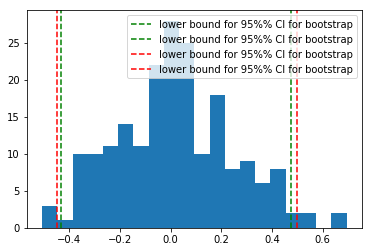

In [48]:
plt.legend()
plt.show()

### Confidence Interval은 기존 CI와 very strictly coincide 한다.

# 2. Bagging - regression

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

### One Model

In [102]:
T = 100
x_axis = np.linspace(0, 2*np.pi, T)
y_axis = np.sin(x_axis)

N = 30
idx = np.random.choice(T, size=N, replace=False)
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]

In [103]:
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain) # 30개의 sample
prediction = model.predict(x_axis.reshape(T, 1)) # 100개에 대한 예측
print("score for 1 tree: ", model.score(x_axis.reshape(T, 1), y_axis))

score for 1 tree:  0.963915164784


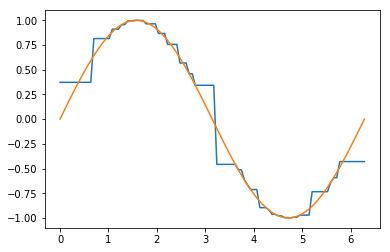

In [104]:
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

### Bagging

In [105]:
class BaggedTreeRegressor:
    def __init__(self, B):
        self.B = B
        
    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]
            
            # mean이 아니라 다른 Bootstrap sample에 대해서 fit decision tree
            model = DecisionTreeRegressor()
            model.fit(Xb, Yb)
            self.models.append(model)
        
    def predict(self, X):
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return predictions / self.B
    
    def score(self, X, Y):
        d1 = Y - self.predict(X)
        d2 = Y - Y.mean()
        return 1 - d1.dot(d1) / d2.dot(d2)

In [106]:
model = BaggedTreeRegressor(100)
model.fit(Xtrain, Ytrain)
print("score for bagged tress: ", model.score(x_axis.reshape(T, 1), y_axis))

score for bagged tress:  0.94819415533


In [100]:
prediction = model.predict(x_axis.reshape(T, 1))

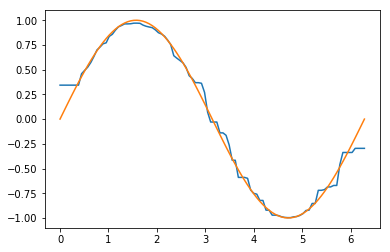

In [101]:
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

항상 Bagging이 더 좋은 score를 내는 것은 아니다.
대신 분산을 줄 것이다.

# 3. Baggging - Classification

In [135]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [136]:
def plot_decision_boundary(X, model):
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [137]:
np.random.seed(10)

In [138]:
N = 500
D = 2
X = np.random.randn(N, D)

sep = 2
X[:125] += np.array([sep, sep])
X[125:250] += np.array([sep, -sep])
X[250:375] += np.array([-sep, -sep])
X[375:] += np.array([-sep, sep])

Y = np.array([0] * 125 + [1] * 125  + [0] * 125 + [1] * 125)

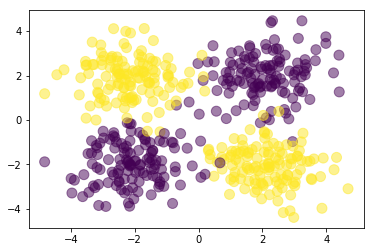

In [139]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=Y, alpha=0.5)
plt.show()

### 1 Decision Tree

In [140]:
model = DecisionTreeClassifier()
model.fit(X, Y)
print("score for 1 tree: ", model.score(X, Y))

score for 1 tree:  1.0


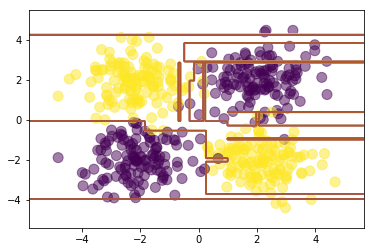

In [141]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()

### Bagging

In [142]:
class BaggedTreeClassifier:
    def __init__(self, B):
        self.B = B
        
    def fit(self, X, Y):
        N = len(X)
        self.models = []
        
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]
            
            model = DecisionTreeClassifier(max_depth=2)
            model.fit(Xb, Yb)
            self.models.append(model)
            
    def predict(self, X):
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return np.round(predictions / B)
    
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(Y==P)

In [143]:
model = BaggedTreeClassifier(200)
model.fit(X, Y)
print("score for bagged model: ", model.score(X, Y))

score for bagged model:  0.968


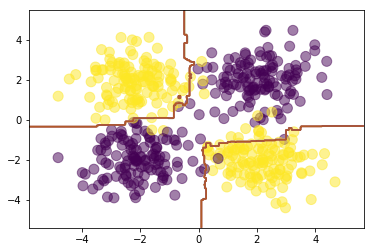

In [144]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()